In [ ]:
!pip install datasets
!pip install transformers
!pip install evaluate
!pip install accelerate -U
!pip install transformers[torch]
!pip install peft
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


Step 1: Set Up Environment
**bold text**

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, TrainingArguments, Trainer, GenerationConfig
import evaluate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model, TaskType

Using device: cuda


Step 2: Load Dataset
**bold text**

In [ ]:
huggingface_dataset_name = "knkarthick/dialogsum"
dataset = load_dataset(huggingface_dataset_name)
print(f"Dataset sizes: {dataset}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dataset sizes: DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})


Step 4: Load Pre-trained Model and Tokenizer
**bold text**

In [ ]:
model_name = "google/flan-t5-base"
base_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base_model = base_model.to(device)

Step 5: Check Trainable Parameters
**bold text**

In [ ]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params:,}\nall model parameters: {all_model_params:,}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(base_model))

trainable model parameters: 247,577,856
all model parameters: 247,577,856
percentage of trainable model parameters: 100.00%


Step 6: Perform Baseline Inference
**bold text**

In [ ]:
i = 20
dialogue = dataset['test'][i]['dialogue']
summary = dataset['test'][i]['summary']

prompt = f"Summarize the following dialogue: {dialogue}\nSummary:"

input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
output = tokenizer.decode(base_model.generate(input_ids, max_new_tokens=200)[0], skip_special_tokens=True)

print(f"Input Prompt: {prompt}")
print("--------------------------------------------------------------------")
print("Human evaluated summary ---->")
print(summary)
print("---------------------------------------------------------------------")
print("Baseline model generated summary: ---->")
print(output)

Input Prompt: Summarize the following dialogue: #Person1#: What's wrong with you? Why are you scratching so much?
#Person2#: I feel itchy! I can't stand it anymore! I think I may be coming down with something. I feel lightheaded and weak.
#Person1#: Let me have a look. Whoa! Get away from me!
#Person2#: What's wrong?
#Person1#: I think you have chicken pox! You are contagious! Get away! Don't breathe on me!
#Person2#: Maybe it's just a rash or an allergy! We can't be sure until I see a doctor.
#Person1#: Well in the meantime you are a biohazard! I didn't get it when I was a kid and I've heard that you can even die if you get it as an adult!
#Person2#: Are you serious? You always blow things out of proportion. In any case, I think I'll go take an oatmeal bath.
Summary:
--------------------------------------------------------------------
Human evaluated summary ---->
#Person1# thinks #Person2# has chicken pox and warns #Person2# about the possible hazards but #Person2# thinks it will be 

Step 7: Tokenize Dataset
**bold text**

In [ ]:
def tokenize_function(example):
    start_prompt = "Summarize the following conversation.\n\n"
    end_prompt = "\n\nSummary: "
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]

    model_inputs = tokenizer(prompt, max_length=512, padding="max_length", truncation=True)
    labels = tokenizer(example["summary"], max_length=128, padding="max_length", truncation=True)
    label_ids = [
        [(token_id if token_id != tokenizer.pad_token_id else -100) for token_id in ids]
        for ids in labels["input_ids"]
    ]

    example['input_ids'] = model_inputs["input_ids"]
    example['attention_mask'] = model_inputs["attention_mask"]
    example['labels'] = label_ids
    return example

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'topic', 'dialogue', 'summary'])
tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 50 == 0, with_indices=True)
print(f"Filtered dataset sizes: {tokenized_datasets}")

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

Filtered dataset sizes: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 30
    })
})


Step 7: Apply PEFT with LoRA Configuration
**bold text**

In [ ]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q", "k", "v", "o"],
)

peft_model_train = get_peft_model(base_model, lora_config)
print(print_number_of_trainable_model_parameters(peft_model_train))

trainable model parameters: 1,769,472
all model parameters: 249,347,328
percentage of trainable model parameters: 0.71%


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Step 9: Define Training Arguments
**bold text**

In [ ]:
output_dir = "./peft-dialogue-summary-training"

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    num_train_epochs=3,
    logging_steps=10,
    save_steps=50,
    save_total_limit=2,
    gradient_checkpointing=True,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=0,
    report_to=None,
    optim="adamw_torch",
)

Step 10: Train the Model
**bold text**

Step,Training Loss
10,0.000000
20,0.000000
30,0.000000
40,0.000000
50,0.000000
60,0.000000
70,0.000000
80,0.000000


Step,Training Loss
10,0.000000
20,0.000000
30,0.000000
40,0.000000
50,0.000000
60,0.000000
70,0.000000
80,0.000000
90,0.000000


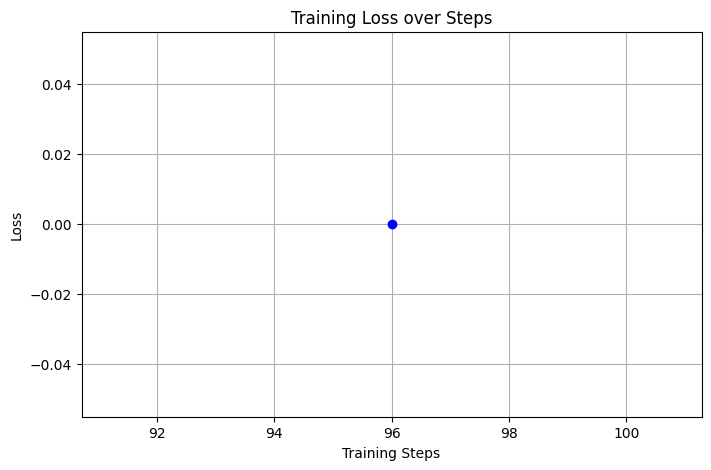

Training completed successfully. Loss plot shown above.


In [ ]:
peft_trainer = Trainer(
    model=peft_model_train,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
)

peft_trainer.train()

log_history = peft_trainer.state.log_history
steps = [log['step'] for log in log_history if 'train_loss' in log]
losses = [log['train_loss'] for log in log_history if 'train_loss' in log]

plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Steps')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

print("Training completed successfully. Loss plot shown above.")

Step 11: Save the Fine-Tuned Model
**bold text**

In [ ]:
peft_model_path = "./peft-dialogue-summary-checkpoint-local"
peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)
print(f"Model saved to {peft_model_path}")

Model saved to ./peft-dialogue-summary-checkpoint-local


Step 12: Load and Test Fine-Tuned Model
**bold text**

In [28]:
from peft import PeftModel

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
peft_model = PeftModel.from_pretrained(peft_model_base, peft_model_path, is_trainable=False)
peft_model = peft_model.to(device)

peft_model_outputs = peft_model.generate(input_ids=input_ids, max_new_tokens=200, num_beams=1)
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

print(f"Input Prompt: {prompt}")
print("--------------------------------------------------------------------")
print("Human evaluated summary ---->")
print(summary)
print("---------------------------------------------------------------------")
print("Baseline model generated summary: ---->")
print(output)
print("---------------------------------------------------------------------")
print("PEFT model generated summary: ---->")
print(peft_model_text_output)

Input Prompt: Summarize the following dialogue: #Person1#: What's wrong with you? Why are you scratching so much?
#Person2#: I feel itchy! I can't stand it anymore! I think I may be coming down with something. I feel lightheaded and weak.
#Person1#: Let me have a look. Whoa! Get away from me!
#Person2#: What's wrong?
#Person1#: I think you have chicken pox! You are contagious! Get away! Don't breathe on me!
#Person2#: Maybe it's just a rash or an allergy! We can't be sure until I see a doctor.
#Person1#: Well in the meantime you are a biohazard! I didn't get it when I was a kid and I've heard that you can even die if you get it as an adult!
#Person2#: Are you serious? You always blow things out of proportion. In any case, I think I'll go take an oatmeal bath.
Summary:
--------------------------------------------------------------------
Human evaluated summary ---->
#Person1# thinks #Person2# has chicken pox and warns #Person2# about the possible hazards but #Person2# thinks it will be 